In [80]:
from dotenv import load_dotenv
import os

load_dotenv(verbose=True)
key = os.getenv('OPENAI_API_KEY')

### Corrective Rag

RAG(Retrieval Augmented Generation) 에서 사용자 질문에 대한 문서 검색 결과를 평가하고, 필요하다면 다른 방법의 검색을 수행하여 <br>
질이 높은 답변을 만들어 내기 위한 프로세스를 포함하는 것입니다. <br>

### PDF 기반 문서 검색기 (Retrieval chain) 생성

In [81]:
from rag.pdf import PDFRetrievalChain

# PDF 문서를 로드
pdf = PDFRetrievalChain(['data/SPRI_AI_Brief_2023년12월호_F.pdf']).create_chain()

pdf_retriever = pdf.retriever       # retriever 생성
pdf_chain = pdf.chain               # pdf retriever chain 생성

### State

In [82]:
from typing import Annotated, List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    그래프의 상태를 나타내는 데이터 모델

    Attributes:
        question: 질문
        generation: LLM 생성된 답변
        web_search: 웹 검색 필요에 대해서 Yes or No 답변 
        documents: 도큐먼트 리스트
    """

    question: Annotated[str, "The question to answer"]
    generation: Annotated[str, "LLM generated answer"]
    web_search: Annotated[str, "Whether to add search"]
    documents: Annotated[List[str], "The documents retrieved"]

### 문서 검색 노드 : 사용자 질문에 대한 PDF 문서를 검색하는 PDF 기반 문서 검색기 (Retrieval chain)

In [83]:
# 문서 검색 노드
def retrieve(state: GraphState):
    # print('\n==========================================================================================')
    # print(f"🔄 [Node] 문서 검색 노드 🔄")
    
    question = state['question']                    # 사용자 질문
    documents = pdf_retriever.invoke(question)      # 문서 검색
    
    # print(f'문서 검색 결과: ')
    # print(documents)

    # print('==========================================================================================\n')
    
    return {'documents': documents}

In [84]:
state = GraphState(
    question='삼성전자가 만든 생성형 AI 이름은?',
    generation = '', 
    web_search = '',
    documents = []
)

In [85]:
answer = retrieve(state)                        # 사용자 질문에 대해서 관련 문서를 검색한다.
state['documents'] = answer['documents']

In [86]:
state

{'question': '삼성전자가 만든 생성형 AI 이름은?',
 'generation': '',
 'web_search': '',
 'documents': [Document(id='4415dd9c-09bc-43d0-b43e-a422c6254c8d', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 1, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10\n▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11\n▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12'),
  Document(id='b9fdae57-2312-4329-a308-055f92e24ce4', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 12, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462

### 사용자 질문에 대한 문서 검색 결과와 사용자 질문의 관련성 평가하는 노드 (Question-Retrieval Evaluation 문서 검색 평가기 노드) 

검색된 문서의 관련성 평가는 검색된 문서가 사용자의 질문과 관련이 있는지 평가합니다.

In [87]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.documents import Document
from pydantic import BaseModel, Field

In [88]:
class GradeDocuments(BaseModel):                    # 문서 평가를 위한 데이터 모델
    """A binary score to determine the relevance of the retrieved document."""

    # 문서가 질문과 관련이 있는지 여부를 'yes' 또는 'no'로 나타내는 필드
    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

llm = ChatOpenAI(
    api_key=key, 
    model='gpt-4o-mini', 
    temperature=0
)


structured_llm_grader = llm.with_structured_output(GradeDocuments)

# 시스템 프롬프트 정의
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""


# 프롬프트 템플릿
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)


# 사용자 질문에 대한 pdf 문서 검색 결과를 평가하는 문서 검색결과 평가기(retrieval_grader)
# 문서 검색 평가기는 사용자 질문과 검색 결과문서가 관련성이 있는지 본다
retrieval_grader = grade_prompt | structured_llm_grader

In [89]:
# 문서 검색 결과와 질문 관련성 평가 노드
def grade_documents(state: GraphState):
    # print('\n==========================================================================================')
    # print('===== [CHECK DOCUMENT RELEVANCE TO QUESTION] =====')

    question = state['question']        # 사용자 질문      
    documents = state['documents']      # 문서 검색 결과

    # 문서 검색 평가기를 통과한 문서들만 필터링
    filtered_docs = []
    relevant_doc_count = 0

    for doc in documents:
        score = retrieval_grader.invoke({'question': question, 'document': doc.page_content})

        grade = score.binary_score

        if grade == 'yes':
            # print("---GRADE: DOCUMENT RELEVANT---")     
            filtered_docs.append(doc)
            relevant_doc_count += 1                     
        else:
            # print("---GRADE: DOCUMENT NOT RELEVANT---") 
            continue     
    
    # 관련 문서가 없으면 웹 검색 수행
    web_search = "Yes" if relevant_doc_count <2  else "No"

    # print(f"yes/no: {web_search}")
    # print('==========================================================================================\n')

    return {'documents': filtered_docs, 'web_search': web_search}

In [90]:
return_documents = grade_documents(state)

In [91]:
state['documents'] = return_documents['documents']
state['web_search'] = return_documents['web_search']

In [92]:
state

{'question': '삼성전자가 만든 생성형 AI 이름은?',
 'generation': '',
 'web_search': 'No',
 'documents': [Document(id='4415dd9c-09bc-43d0-b43e-a422c6254c8d', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 1, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10\n▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11\n▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12'),
  Document(id='b9fdae57-2312-4329-a308-055f92e24ce4', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 12, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.134

### 쿼리 재작성 (Query Rewriter) 노드

In [93]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser


llm = ChatOpenAI(
    api_key=key, 
    model='gpt-4o-mini', 
    temperature=0
)

# Query Rewriter 프롬프트
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""

re_writer_prompt = ChatPromptTemplate.from_messages(
    [
        ('system', system), 
        ('human', 'Here is the initial question: \n\n {question} \n Formulate an improved question')
    ]
)

# Query Rewriter 생성
question_rewriter = re_writer_prompt | llm | StrOutputParser()

In [94]:
# Query Rewrite 노드
def query_rewrite(state: GraphState):
    # print('\n==========================================================================================')
    # print('🔄 [Node] 쿼리 재작성 노드 🔄')


    question = state['question']        # 사용자 질문    
    documents = state['documents']      # 문서 검색 결과
    
    # 쿼리 재작성
    better_question = question_rewriter.invoke({'question': question})
    
    # print(f"better_question: {better_question}")
    # print('==========================================================================================\n')

    return {'question': better_question}

In [95]:
question_rewriter_return = query_rewrite(state)
state['question'] = question_rewriter_return['question']

In [96]:
state

{'question': '삼성전자가 개발한 생성형 AI의 이름은 무엇인가요?',
 'generation': '',
 'web_search': 'No',
 'documents': [Document(id='4415dd9c-09bc-43d0-b43e-a422c6254c8d', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 1, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10\n▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11\n▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12'),
  Document(id='b9fdae57-2312-4329-a308-055f92e24ce4', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 12, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10

### 웹 검색 노드

In [97]:
from langchain_teddynote.tools.tavily import TavilySearch
from langchain_core.documents import Document

web_search_tool = TavilySearch(max_results=2)

In [98]:
# 웹 검색 노드
def web_search(state):
    # print('\n==========================================================================================')
    # print('🔄 [Node] 웹 검색 노드 🔄')

    # 사용자 질문
    question = state['question']
    
    # print(f"question: ")
    # print(question)
    # print()

    # 웹 검색 수행
    web_results = web_search_tool.invoke({"query": question})

    # print('-------------------')
    # print('web_results: ')
    # print(web_results)
    # print('-------------------')
    # print()

    web_results_docs = []
    
    for result in web_results:
        doc = Document(
            page_content=result["content"],
            metadata={"source": result["url"]}
        )
        web_results_docs.append(doc)


    # print('web_results_docs: ')
    # print(web_results_docs)

    # print('==========================================================================================\n')

    return {"documents": web_results_docs}

In [99]:
web_search(state)

{'documents': [Document(metadata={'source': 'https://www.yna.co.kr/view/AKR20231108041400003'}, page_content="삼성전자, 자체 개발한 생성형 AI '삼성 가우스' 첫 공개 | 연합뉴스 삼성전자, 자체 개발한 생성형 AI '삼성 가우스' 첫 공개 삼성전자, 자체 개발한 생성형 AI '삼성 가우스' 첫 공개 삼성전자[005930]가 자체 개발한 생성형 인공지능(AI) 모델 '삼성 가우스'(Samsung Gauss)가 처음 공개됐다. (서울=연합뉴스) 장하나 기자 = 삼성전자[005930]가 자체 개발한 생성형 인공지능(AI) 모델 '삼성 가우스'(Samsung Gauss)가 처음 공개됐다. 환영사 하는 김대현 부사장(서울=연합뉴스) 김대현 삼성전자 부사장이 8일 서울 서초구 삼성전자 서울R&D캠퍼스에서 열린 '삼성 AI 포럼 2023'에서 환영사를 하고 있다. 삼성전자가 자체 개발한 생성형 AI '삼성 가우스'[삼성전자 제공. 강연하는 제이슨 웨이 오픈AI 연구원(서울=연합뉴스) 제이슨 웨이 삼성 오픈AI 연구원이 8일 서울 서초구 삼성전자 서울R&D캠퍼스에서 열린 '삼성 AI 포럼 2023'에서 '대규모 언어 모델 르네상스의 새로운 패러다임'을 주제로 강연하고 있다."),
  Document(metadata={'source': 'https://www.yna.co.kr/view/AKR20231108041400003'}, page_content="삼성전자, 자체 개발한 생성형 AI '삼성 가우스' 첫 공개 | 연합뉴스 삼성전자, 자체 개발한 생성형 AI '삼성 가우스' 첫 공개 삼성전자, 자체 개발한 생성형 AI '삼성 가우스' 첫 공개 삼성전자[005930]가 자체 개발한 생성형 인공지능(AI) 모델 '삼성 가우스'(Samsung Gauss)가 처음 공개됐다. (서울=연합뉴스) 장하나 기자 = 삼성전자[005930]가 자체 개발한 생성형 인공지능(AI) 모델 '삼성 가우스'(Sa

### 웹 검색을 할 것인지 답변을 생성할 것인지 판단하는 라우팅 (조건부 엣지 함수)

In [100]:
def decide_to_generate(state: GraphState):
    print('\n==========================================================================================')
    print('🔄 [Node] 문서 관련성 평가 노드 ASSESS GRADED DOCUMENTS 🔄')
    # print('===== [ASSESS GRADED DOCUMENTS] decide_to_generate() 함수 =====')

    # 웹 검색 할지를 가져온다
    web_search = state["web_search"]


    if web_search == "Yes":     # 웹 검색으로 정보 보강이 필요한 경우        
        print(
            "==== [DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, QUERY REWRITE] ===="
        )
        print('query_rewrite')
        print('==========================================================================================\n')
        
        return "query_rewrite"  

    else:                       # 관련 문서가 존재하므로 답변 생성 단계(generate) 로 진행        
        print("==== [DECISION: GENERATE] ====")
        print('generate')
        print('==========================================================================================\n')
        
        return "generate"

In [101]:
decide_to_generate(state)


🔄 [Node] 문서 관련성 평가 노드 ASSESS GRADED DOCUMENTS 🔄
==== [DECISION: GENERATE] ====
generate



'generate'

### 사용자 질문에 대한 답변을 생성하는 노드 (답변 생성을 위한 RAG 체인을 실행하여 답변을 생성)

In [102]:
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI
from langchain import hub

# prompt = hub.pull("teddynote/rag-prompt")

template = """You are an AI assistant specializing in Question-Answering (QA) tasks within a Retrieval-Augmented Generation (RAG) system. 
Your primary mission is to answer questions based on provided context or chat history.
Ensure your response is concise and directly addresses the question without any additional narration.

###

Your final answer should be written concisely (but include important numerical values, technical terms, jargon, and names), followed by the source of the information.

# Steps

1. Carefully read and understand the context provided.
2. Identify the key information related to the question within the context.
3. Formulate a concise answer based on the relevant information.
4. Ensure your final answer directly addresses the question.
5. List the source of the answer in bullet points, which must be a file name (with a page number) or URL from the context. Omit if the source cannot be found.

# Output Format:
[Your final answer here, with numerical values, technical terms, jargon, and names in their original language]

**Source**(Optional)
- (Source of the answer, must be a file name(with a page number) or URL from the context. Omit if you can't find the source of the answer.)
- (list more if there are multiple sources)
- ...

###

Remember:
- It's crucial to base your answer solely on the **PROVIDED CONTEXT**. 
- DO NOT use any external knowledge or information not present in the given materials.
- If you can't find the source of the answer, you should answer that you don't know.

###

# Here is the user's QUESTION that you should answer:
{question}

# Here is the CONTEXT that you should use to answer the question:
{context}

# Your final ANSWER to the user's QUESTION:"""

prompt = ChatPromptTemplate.from_template(template)

llm = ChatOpenAI(
    api_key=key, 
    model='gpt-4o-mini', 
    temperature=0
)

def format_docs(docs):
    return "\n\n".join(
        [
            f'<document><content>{doc.page_content}</content><source>{doc.metadata["source"]}</source><page>{doc.metadata["page"]+1}</page></document>'
            for doc in docs
        ]
    )

output_parser = StrOutputParser()

# RAG 체인 생성 (pdf_retriever 문서 검색기를 사용해서 얻은 문서와 사용자 질문을 넣어서 결과)
rag_chain = prompt | llm | output_parser

In [103]:
# 답변 생성 노드
def generate(state: GraphState):
    # print('\n==========================================================================================')
    # print('🔄 [Node] 답변 생성 노드 🔄')
    # print('===== [GENERATE] generate() 함수 =====')

    # 사용자 질문
    question = state['question']  

    # 문서 검색 결과
    documents = state['documents']

    # RAG 실행 결과
    generation = rag_chain.invoke({'context': documents , 'question': 'question'})

    # print(f'사용자 질문: {question}')
    # print(f'문서 검색 결과:')
    # print(documents)
    # print()
    # print(f'rag 실행 결과:')
    # print(generation)
    # print()
    # print('==========================================================================================\n')    

    return {'generation': generation}

In [104]:
state['generation'] = generate(state)['generation']

In [105]:
state

{'question': '삼성전자가 개발한 생성형 AI의 이름은 무엇인가요?',
 'generation': '삼성전자가 공개한 생성 AI 모델 ‘삼성 가우스’는 언어, 코드, 이미지의 3개 모델로 구성되어 있으며, 온디바이스에서 작동하여 사용자 정보 유출 위험이 없다. 이 모델은 2023년 11월 8일 ‘삼성 AI 포럼 2023’에서 처음 소개되었다.\n\n**Source**\n- data/SPRI_AI_Brief_2023년12월호_F.pdf (page 12)',
 'web_search': 'No',
 'documents': [Document(id='4415dd9c-09bc-43d0-b43e-a422c6254c8d', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 1, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10\n▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11\n▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12'),
  Document(id='b9fdae57-2312-4329-a

In [106]:
from langgraph.graph import StateGraph, END, START
from langchain_teddynote.graphs import visualize_graph

In [107]:
######### 1. 그래프 생성 #########

workflow = StateGraph(GraphState)

In [108]:
######### 2. 노드 정의  #########

workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("query_rewrite", query_rewrite)
workflow.add_node("web_search_node", web_search)

In [109]:
######### 3. 그래프 엣지(Edge) 추가  #########

workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")

In [110]:
# 문서 평가 노드에서 조건부 엣지 추가
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "query_rewrite": "query_rewrite",
        "generate": "generate",
    },
)

In [111]:
# 엣지 연결
workflow.add_edge("query_rewrite", "web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", END)

In [112]:
######### 6. 그래프 컴파일(compile)  #########

app = workflow.compile()

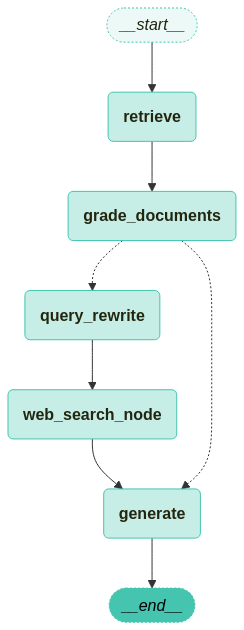

In [113]:
visualize_graph(app)

In [114]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, invoke_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = {
    "question": "삼성전자가 개발한 생성형 AI 의 이름은?",
}

for event in app.stream(inputs, config=config):
    for node_name, node_chunk in event.items():
        print('[node_name]:', node_name)
        print('[node_chunk]:\n', node_chunk)

[node_name]: retrieve
[node_chunk]:
 {'documents': [Document(id='b9fdae57-2312-4329-a308-055f92e24ce4', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 12, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='SPRi AI Brief |\n2023-12월호\n삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개\nKEY Contents\nn 삼성전자가 온디바이스에서 작동 가능하며 언어, 코드, 이미지의 3개 모델로 구성된 자체 개발 생성\nAI 모델 ‘삼성 가우스’를 공개\nn 삼성전자는 삼성 가우스를 다양한 제품에 단계적으로 탑재할 계획으로, 온디바이스 작동이 가능한\n삼성 가우스는 외부로 사용자 정보가 유출될 위험이 없다는 장점을 보유\n£언어, 코드, 이미지의 3개 모델로 구성된 삼성 가우스, 온디바이스 작동 지원'), Document(id='4415dd9c-09bc-43d0-b43e-a422c6254c8d', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 1, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'H

In [115]:
config = RunnableConfig(                        # config 설정
    recursion_limit=20,                         # 최대 20개의 노드까지 방문.
    configurable={'thread_id': random_uuid()}   # thread_id 설정
)

inputs = GraphState(question='삼성전자가 만든 생성형 AI')

i = 1

for chunk in app.stream(inputs, config=config, stream_mode="updates"):
    print(f"===== for 시작 {i} =====")

    j = 1
    
    for state_key, state_value in chunk.items():
        print(f"== for 시작 {i} - {j} ==")
        print(f"state_key : {state_key }")
        print(f"state_value: \n {state_value}")
        print(f"== for  끝 {i} - {j}==")

        j=j+1
    
    print(f"===== for 끝 {i} =====")
    i=i+1

===== for 시작 1 =====
== for 시작 1 - 1 ==
state_key : retrieve
state_value: 
 {'documents': [Document(id='4415dd9c-09bc-43d0-b43e-a422c6254c8d', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 1, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10\n▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11\n▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12'), Document(id='b9fdae57-2312-4329-a308-055f92e24ce4', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 12, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462'

In [116]:
config = RunnableConfig(                        # config 설정
    recursion_limit=20,                         # 최대 20개의 노드까지 방문.
    configurable={'thread_id': random_uuid()}   # thread_id 설정
)

inputs = GraphState(question='대구 짜장면?')

i = 1

for chunk in app.stream(inputs, config=config, stream_mode="updates"):
    print(f"===== for 시작 {i} =====")

    j = 1
    
    for state_key, state_value in chunk.items():
        print(f"== for 시작 {i} - {j} ==")
        print(f"state_key : {state_key }")
        print(f"state_value: \n {state_value}")
        print(f"== for  끝 {i} - {j}==")

        j=j+1
    
    print(f"===== for 끝 {i} =====")
    i=i+1

===== for 시작 1 =====
== for 시작 1 - 1 ==
state_key : retrieve
state_value: 
 {'documents': [Document(id='ddcc9b6a-3ed9-479c-a918-8c3fa7895ba9', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 19, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='<갈릴레오의 LLM 환각 지수(RAG 포함 질문과 답변 기준)>\n☞ 출처: Galileo, LLM Hallucination Index, 2023.11.15.'), Document(id='ef15ae0c-b050-4902-a300-2fcf907c0a08', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 19, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='환각을 평가하고 측정하는 구조화된 접근방식

In [119]:
config = RunnableConfig(                        # config 설정
    recursion_limit=20,                         # 최대 20개의 노드까지 방문.
    configurable={'thread_id': random_uuid()}   # thread_id 설정
)

inputs = GraphState(question='삼성전자가 만든 생성형 AI')

i = 1

for chunk in app.stream(inputs, config=config, stream_mode="updates"):
    print(f"===== for 시작 {i} =====")

    j = 1
    
    for state_key, state_value in chunk.items():
        print(f"== for 시작 {i} - {j} ==")
        print(f"state_key : {state_key }")
        # print(f"state_value: \n {state_value}")


        if state_key == 'web_search_node':
            print('------------------------------')
            print(f"🔄 [Node] 웹 검색 노드 🔄")
            print(f"{state_value['documents']}")
            print('------------------------------')
            print()
        elif state_key == 'retrieve':
            print('------------------------------')
            print(f"🔄 [Node] 문서 검색 노드 🔄")
            print(f"{state_value['documents']}")
            print('------------------------------')
            print()
        elif state_key == 'grade_documents':
            print('------------------------------')
            print(f"🔄 [Node] CHECK DOCUMENT RELEVANCE TO QUESTION 🔄")
            print(f"{state_value['documents']}")
            print(f"{state_value['web_search']}")
            print('------------------------------')
            print()
        elif state_key == 'query_rewrite':
            print('------------------------------')
            print(f"🔄 [Node] 문서 관련성 평가 노드 🔄")
            print(f"{state_value['question']}")
            print('------------------------------')
            print()
        elif state_key == 'generate':
            print('------------------------------')
            print(f"🔄 [Node] 답변 생성 노드 🔄")
            print(f"{state_value['generation']}")
            print('------------------------------')
            print()

        print(f"== for  끝 {i} - {j}==")

        j=j+1
    
    print(f"===== for 끝 {i} =====")
    i=i+1

===== for 시작 1 =====
== for 시작 1 - 1 ==
state_key : retrieve
------------------------------
🔄 [Node] 문서 검색 노드 🔄
[Document(id='4415dd9c-09bc-43d0-b43e-a422c6254c8d', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 1, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10\n▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11\n▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12'), Document(id='b9fdae57-2312-4329-a308-055f92e24ce4', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 12, 'total_pages': 23, 'Author': 'dj', 'Creator': '

In [120]:
config = RunnableConfig(                        # config 설정
    recursion_limit=20,                         # 최대 20개의 노드까지 방문.
    configurable={'thread_id': random_uuid()}   # thread_id 설정
)

inputs = GraphState(question='삼성전자가 만든 생성형 AI')


for chunk in app.stream(inputs, config=config, stream_mode="updates"):
    
    for state_key, state_value in chunk.items():

        if state_key == 'web_search_node':
            print('------------------------------')
            print(f"🔄 [Node] 웹 검색 노드 🔄")
            print(f"{state_value['documents']}")
            print('------------------------------')

        elif state_key == 'retrieve':
            print('------------------------------')
            print(f"🔄 [Node] 문서 검색 노드 🔄")
            print(f"{state_value['documents']}")
            print('------------------------------')
            
        elif state_key == 'grade_documents':
            print('------------------------------')
            print(f"🔄 [Node] CHECK DOCUMENT RELEVANCE TO QUESTION 🔄")
            print(f"{state_value['documents']}")
            print(f"{state_value['web_search']}")
            print('------------------------------')
            
        elif state_key == 'query_rewrite':
            print('------------------------------')
            print(f"🔄 [Node] 문서 관련성 평가 노드 🔄")
            print(f"{state_value['question']}")
            print('------------------------------')
        
        elif state_key == 'generate':
            print('------------------------------')
            print(f"🔄 [Node] 답변 생성 노드 🔄")
            print(f"{state_value['generation']}")
            print('------------------------------')
            

------------------------------
🔄 [Node] 문서 검색 노드 🔄
[Document(id='4415dd9c-09bc-43d0-b43e-a422c6254c8d', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 1, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='▹ 삼성전자, 자체 개발 생성 AI ‘삼성 가우스’ 공개 ···························································10\n▹ 구글, 앤스로픽에 20억 달러 투자로 생성 AI 협력 강화 ················································11\n▹ IDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망···········································12'), Document(id='b9fdae57-2312-4329-a308-055f92e24ce4', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 12, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', '

In [123]:
config = RunnableConfig(                        # config 설정
    recursion_limit=20,                         # 최대 20개의 노드까지 방문.
    configurable={'thread_id': random_uuid()}   # thread_id 설정
)

inputs = GraphState(question='대구 동성로 떡볶이에 대해서 알려주세요')


for chunk in app.stream(inputs, config=config, stream_mode="updates"):
    
    for state_key, state_value in chunk.items():

        if state_key == 'web_search_node':
            print('------------------------------')
            print(f"🔄 [Node] 웹 검색 노드 🔄")
            print(f"{state_value['documents']}")
            print('------------------------------')

        elif state_key == 'retrieve':
            print('------------------------------')
            print(f"🔄 [Node] 문서 검색 노드 🔄")
            print(f"{state_value['documents']}")
            print('------------------------------')
            
        elif state_key == 'grade_documents':
            print('------------------------------')
            print(f"🔄 [Node] CHECK DOCUMENT RELEVANCE TO QUESTION 🔄")
            print(f"{state_value['documents']}")
            print(f"{state_value['web_search']}")
            print('------------------------------')
            
        elif state_key == 'query_rewrite':
            print('------------------------------')
            print(f"🔄 [Node] 문서 관련성 평가 노드 🔄")
            print(f"{state_value['question']}")
            print('------------------------------')
        
        elif state_key == 'generate':
            print('------------------------------')
            print(f"🔄 [Node] 답변 생성 노드 🔄")
            print(f"{state_value['generation']}")
            print('------------------------------')
            

------------------------------
🔄 [Node] 문서 검색 노드 🔄
[Document(id='bc5f2bc9-48ba-4191-9c5f-0ba291261724', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 22, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='홈페이지 : https://spri.kr/\n보고서와 관련된 문의는 AI정책연구실(jayoo@spri.kr, 031-739-7352)으로 연락주시기 바랍니다.'), Document(id='a82ccb23-5f61-40bc-b5a5-78b8f79d9984', metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 6, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='특정 작품과의 실질적 유사성을 입증할 수 없다면 저작권 침해를 인정받기 어려움\nn 오릭 판사는 원고 측에 고소장